In [1]:
import quantus
import json
from helpers.data import load_sample_data, denormalizer, get_label_name
from helpers.plots import get_img_lrp_flat, plot_spyder_graph

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import torchvision

from zennit.torchvision import VGGCanonizer
from zennit import attribution as zattr
from zennit import composites as zcomp
from zennit import image as zimage


## 1) Load Data

In [2]:
img_path = 'example_data/imgs'
annotations_dir = 'example_data/annotations'
label_map_path = 'example_data/label-map-imagenet.json'

with open(label_map_path) as label_map_file:
        label_map = json.load(label_map_file)
        
x_batch, s_batch, y_batch = load_sample_data(img_path, annotations_dir, label_map)

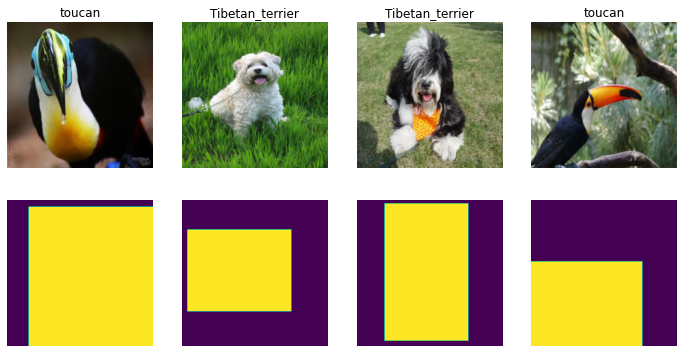

In [3]:
size = 3
num_rows = 2
ncols = len(x_batch)
fig, axs = plt.subplots(nrows=num_rows, ncols=ncols, figsize=(ncols * size, num_rows * size))

for i, (img, seg_mask, label) in enumerate(zip(x_batch, s_batch, y_batch)):
    axs[0][i].imshow(np.moveaxis(denormalizer(img).numpy(), 0, 2))
    axs[0][i].set_title(get_label_name(label_map, label))
    axs[1][i].imshow(seg_mask[0].numpy())
    axs[0][i].axis('off'); axs[1][i].axis('off')

## 2) Load Model (here: VGG-16)

In [4]:
device = 'cpu'
model = torchvision.models.vgg16_bn(
    weights=torchvision.models.VGG16_BN_Weights.DEFAULT
).to(device).eval()

## 3) Define Metrics

In [5]:
# Define 

metrics =  {
            "Robustness": quantus.AvgSensitivity(**{"nr_samples": 10,
                                     "perturb_std": 0.2,
                                     "norm_numerator": quantus.fro_norm,
                                     "norm_denominator": quantus.fro_norm,
                                     "perturb_func": quantus.uniform_noise,
                                     "similarity_func": quantus.difference,
                                     "disable_warnings": True}),
            "Localisation": quantus.RelevanceRankAccuracy(**{"abs": True,  
                                            "normalise": True,
                                            "disable_warnings": True}),
            "Complexity": quantus.Sparseness(**{"abs": True,  
                                 "normalise": True,
                                 "disable_warnings": True}),
            "Faithfulness": quantus.FaithfulnessCorrelation(**{"nr_runs": 50,  
                                              "subset_size": 224,  
                                              "perturb_baseline": 0,
                                              "perturb_func": quantus.baseline_replacement_by_indices,
                                              "similarity_func": quantus.correlation_pearson,  
                                              "return_aggregate": True,
                                              "abs": False,  
                                              "normalise": True,
                                              "disable_warnings": True})
           }

## 4) Define Explainers

In [6]:
# Define XAI methods to be evaluated
import torch
from captum.attr import Saliency


def wrap_captum(func_attr_captum, model, inputs, targets, device,  *args, **kwargs):
    img_size = kwargs.get('img_size', 224)
    inputs=torch.Tensor(inputs).reshape(-1, 3, img_size, img_size).to(device)
    targets = torch.as_tensor(targets).long().to(device)
    attribution = func_attr_captum(model, inputs, targets, *args, **kwargs)
    return attribution.cpu().detach().numpy()

def wrap_lrp_quantus(canonizer, model, inputs, targets, device, *args, **kwargs):
    attribution = quantus.explain(
        model.eval(), 
        inputs, 
        targets, 
        canonizer=canonizer,
        device=device,
        method="custom",
        *args, 
        **kwargs
    )
    return attribution

def func_captum_saliency(model, inputs, targets, *args, **kwargs):
    attribution = (
        Saliency(model)
            .attribute(inputs, targets, abs=False)
            .sum(axis=1)
    )
    return attribution.cpu().data

def explainer_saliency(model, inputs, targets,  *args, **kwargs):
    return wrap_captum(func_captum_saliency, model, inputs, targets, *args, **kwargs)

def explainer_lrp(model, inputs, targets, device, *args, **kwargs):
    canonizer = None
    return wrap_lrp_quantus(canonizer, model, inputs, targets, device, *args, **kwargs)

def explainer_lrp_canonized(model, inputs, targets, device, *args, **kwargs):
    canonizer = VGGCanonizer
    return wrap_lrp_quantus(canonizer, model, inputs, targets, device, *args, **kwargs)

xai_methods = {
        'saliency': explainer_saliency,
        'lrp': explainer_lrp,
        'lrp_canonized': explainer_lrp_canonized
    }

## 5) Get Explanations and create Heatmaps

In [7]:
xai_lib = 'zennit'
composite = zcomp.EpsilonPlus
attributor = zattr.Gradient
    
attributions = {xai_method: explainer(model=model,
                                       inputs=x_batch.detach().cpu().numpy(),
                                       targets=y_batch.detach().cpu().numpy(),
                                       device=device,
                                       xai_lib=xai_lib,
                                       attributor=attributor,
                                       composite=composite,
                                       normalise=False)
               for xai_method, explainer in xai_methods.items()}

/home/pahde/anaconda3/envs/quantus_eval/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


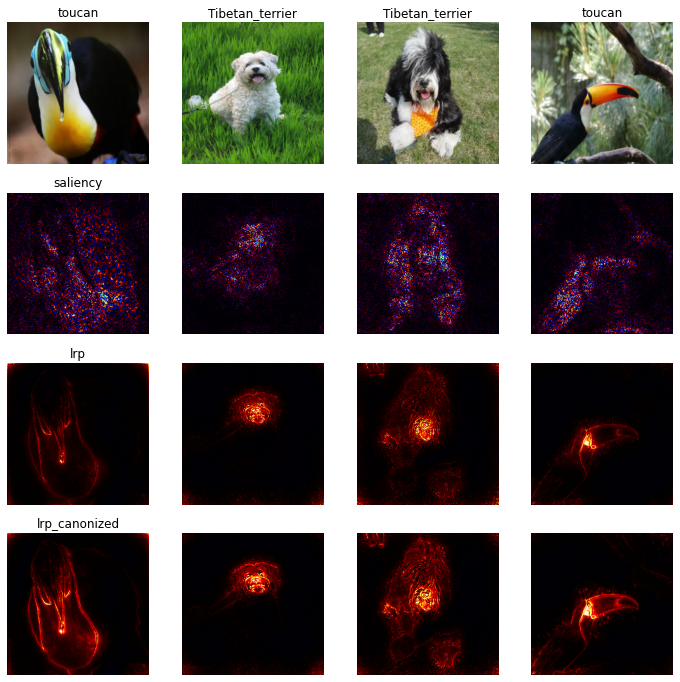

In [8]:
size = 3
num_rows = 1 + len(xai_methods.keys())
ncols = len(x_batch)
fig, axs = plt.subplots(nrows=num_rows, ncols=ncols, figsize=(ncols * size, num_rows * size))

for i, (img, label) in enumerate(zip(x_batch, y_batch)):
    axs[0][i].imshow(np.moveaxis(denormalizer(img).numpy(), 0, 2))
    axs[0][i].set_title(get_label_name(label_map, label))
    axs[0][i].axis('off'); axs[1][i].axis('off')
    
    for j, (xai_method_name, a_batch) in enumerate(attributions.items()):
        img_attr = zimage.imgify(get_img_lrp_flat(a_batch[i].squeeze()), vmin=0, vmax=1., level=2.0, cmap='coldnhot')
        axs[j+1][0].set_title(xai_method_name)
        axs[j+1][i].imshow(img_attr)
        axs[j+1][i].axis('off')

## 6) Compute metrics for all explainers

In [9]:
results = {}

# Iterate over XAI methods
for xai_method_name, xai_method_func in xai_methods.items():
    results[xai_method_name] = {}
    # Iterate over XAI metrics
    for metric_name, metric_func in metrics.items():   
        print(f"Eval explainer '{xai_method_name}' with metric: {metric_name}")
        scores = metric_func(model=model,
                                     x_batch=x_batch.detach().cpu().numpy(),
                                     y_batch=y_batch.detach().cpu().numpy(),
                                     a_batch=None,
                                     s_batch=s_batch.detach().cpu().numpy(),
                                     **{"explain_func": xai_method_func,
                                         "device": device,
                                         "xai_lib": xai_lib,
                                         "composite": composite,
                                         "attributor": attributor
                                         })
        results[xai_method_name][metric_name] = scores

Eval explainer 'saliency' with metric: Robustness


Eval explainer 'saliency' with metric: Localisation


Eval explainer 'saliency' with metric: Complexity


Eval explainer 'saliency' with metric: Faithfulness


Eval explainer 'lrp' with metric: Robustness


Eval explainer 'lrp' with metric: Localisation


Eval explainer 'lrp' with metric: Complexity


Eval explainer 'lrp' with metric: Faithfulness


Eval explainer 'lrp_canonized' with metric: Robustness


Eval explainer 'lrp_canonized' with metric: Localisation


Eval explainer 'lrp_canonized' with metric: Complexity


Eval explainer 'lrp_canonized' with metric: Faithfulness




## 7) Aggregate and Visualize Results

In [10]:
## Aggregate results (take mean) and store as pd.DataFrame

results_agg = {xai_method: 
               {metric_name: np.array(values).mean() for metric_name, values in res.items()} 
               for xai_method, res in results.items()}

df_results = pd.DataFrame.from_dict(results_agg).T.abs().sort_index(axis=1)
df_results

,Complexity,Faithfulness,Localisation,Robustness
saliency,0.597960,0.009416,0.692961,0.064651
lrp,0.647952,0.040127,0.662016,0.000018
lrp_canonized,0.667954,0.062879,0.684654,0.000001


In [11]:
## Turn raw values into ranking

desc_sort_cols = ['Robustness', 'Randomisation']

df_normalised = df_results.apply(lambda x: x / x.max())

for col in desc_sort_cols:
    if col in df_results.columns:
        df_normalised[col] = df_results[col].min()/df_results[col].values  

df_rankings = df_normalised.rank()

In [12]:
df_rankings

,Complexity,Faithfulness,Localisation,Robustness
saliency,1.0,1.0,3.0,1.0
lrp,2.0,2.0,1.0,2.0
lrp_canonized,3.0,3.0,2.0,3.0


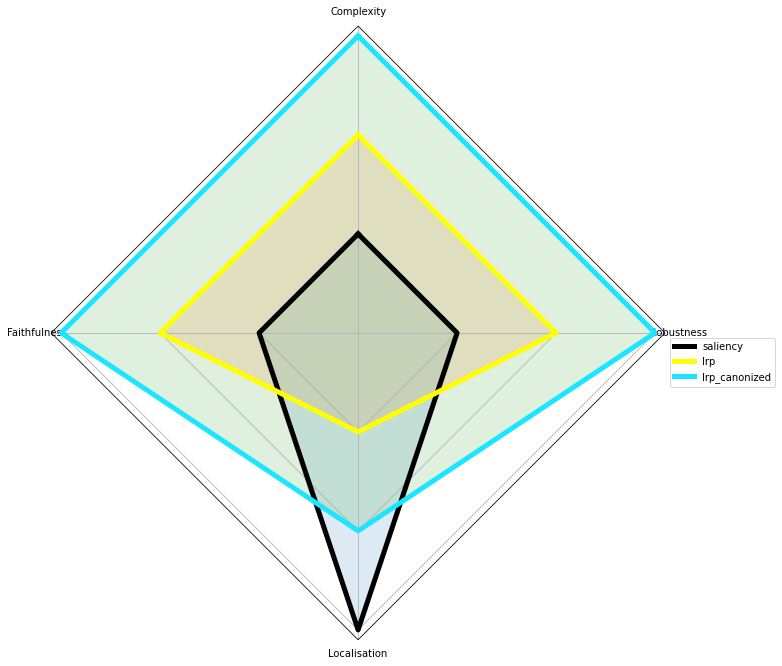

In [13]:
plot_spyder_graph(df_rankings)